<a href="https://colab.research.google.com/github/Morganite-Hub/Homemade-applet/blob/main/Worldcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Authenticate and access Google Cloud services
from google.colab import files
from google.colab import auth
auth.authenticate_user()

### Query data from restaurant data file

In [ ]:
# Import the necessary libraries
from google.cloud import storage
from google.cloud import bigquery

# First make connection to BigQuery
# Replace 'your-project-id' with your Google Cloud project ID
# Replace 'your-dataset-name' with your dataset name
project_id = "whyso-project-0621"
dataset_name = "restaurant_dataset"
table_name = "restaurant_tips" # if you make changes previously, then here you need to make according change

bigquery_client = bigquery.Client(project=project_id)

In [ ]:
# Query all data from the table
query = f"""
    SELECT *
    FROM `{project_id}.{dataset_name}.{table_name}`

"""

query_job = bigquery_client.query(query)
results = query_job.result()

tips_df = query_job.to_dataframe()
tips_df.head()

,user_id,business_id,text,date,compliment_count
0,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10+00:00,0
1,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,Turkey and roast beef,2012-10-11 13:04:02+00:00,0
2,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,Coffee and baby bread,2012-10-24 12:37:05+00:00,0
3,boRCdL8ez95KwzWe69VoUg,QoezRbYQncpRqyrLH6Iqjg,Such a great place to come and get a Cuban san...,2016-10-02 16:53:40+00:00,0
4,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,My last time. Continental and a Cuban,2012-11-09 18:51:34+00:00,0


In [ ]:
!pip install contractions
import re
import string
import contractions
import nltk
import gensim
from gensim.utils import simple_preprocess
import spacy
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

target_column = 'text'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# drop data with missing values in the 'content' column
tips_df = tips_df.dropna(subset=[target_column])

# drop duplicate review content
tips_df = tips_df.drop_duplicates(subset=[target_column])

# remove contraction
tips_df[target_column] = tips_df[target_column].map(lambda x: contractions.fix(x))

# convert the relevant column to lowercase
tips_df[target_column] = tips_df[target_column].str.lower()

# Remove overspace
tips_df[target_column] = tips_df[target_column].map(lambda x: re.sub('\s{2,}', " ", x))

# Remove non-word characters, so numbers and ___ etc
tips_df[target_column] = tips_df[target_column].str.replace("[^A-Za-z]", " ", regex = True)

# Remove punctuation
tips_df[target_column] = tips_df[target_column].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

In [ ]:
# @title Default title text
# create a list of the contents from the 'contents' column
words = tips_df[target_column].tolist()

# tokenise the words
word_tokens = []
for content in words:
    word_tokens.append(word_tokenize(content))

# create bigram model
bigram = gensim.models.phrases.Phrases(word_tokens, min_count=3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a trigram/bigram

# NLTK Stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['and']) #add more stopwords here

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define functions for stopwords, bigrams and lemmatisation
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove stopwords
data_words_nostops = remove_stopwords(word_tokens)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatisation keeping only noun, adj, vb, adv
data_lemmatised = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# put the tokens back together as text to have our filtered contents

rejoin = []
for content in data_lemmatised: # Here we choose to use stemming instead of lemmatisation
    x = " ".join(content) # join the text back together
    rejoin.append(x)

# add the reformed text to the data frame
tips_df['cleaned_review'] = rejoin

In [ ]:
tips_df.head()

,user_id,business_id,text,date,compliment_count,cleaned_review
0,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,they have lots of good deserts and tasty cuban...,2013-02-05 18:35:10+00:00,0,lot good desert tasty cuban_sandwiche
1,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,turkey and roast beef,2012-10-11 13:04:02+00:00,0,
2,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,coffee and baby bread,2012-10-24 12:37:05+00:00,0,coffee baby bread
3,boRCdL8ez95KwzWe69VoUg,QoezRbYQncpRqyrLH6Iqjg,such a great place to come and get a cuban san...,2016-10-02 16:53:40+00:00,0,great place come get cuban_sandwich smell brea...
4,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,my last time continental and a cuban,2012-11-09 18:51:34+00:00,0,last time cuban


### Build the LDA model

<ipython-input-79-6f744ac64ccf>:10: RuntimeWarning: `words` should be an iterable of str.
  mdl.add_doc(words)
<ipython-input-79-6f744ac64ccf>:11: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(20)


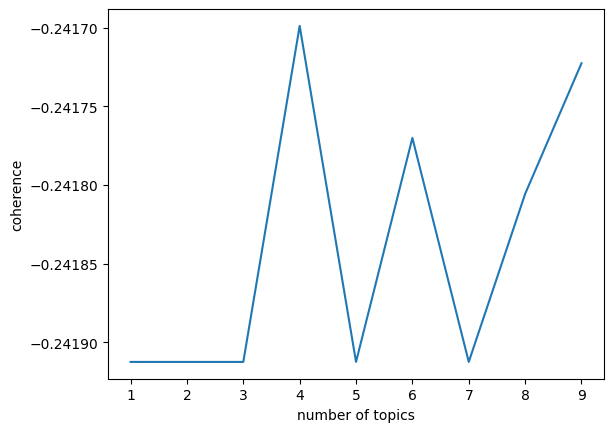

In [ ]:
!pip install tomotopy
import tomotopy as tp
import matplotlib.pyplot as plt
def find_k(docs,min_k=1,max_k=20,min_df=2):
  scores = []
  for k in range(min_k,max_k):
    mdl = tp.LDAModel(min_df=min_df,k=k,seed = 555)
    for words in docs:
      if words:
        mdl.add_doc(words)
    mdl.train(20)
    coh = tp.coherence.Coherence(mdl)
    scores.append(coh.get_score())
  plt.plot(range(min_k,max_k),scores)
  plt.xlabel('number of topics')
  plt.ylabel('coherence')
  plt.show()

find_k(docs=tips_df['cleaned_review'],min_k=1,max_k=10,min_df=2)

In [ ]:
# vectorise the data into word counts

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

max_words = 1000 #how many words taking account for topic modeling
vectorizer = CountVectorizer(max_features=max_words)
vec = vectorizer.fit_transform(tips_df['cleaned_review'])

k = 4 #this is the number of the topic. you can decide the number

lda = LDA(n_components=k, max_iter=5, learning_method='online', random_state = 10)
lda.fit(vec)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=4,
                          random_state=10)

### Visualisation of the topics

Topic#  1
love,good,try,place,always,friendly,ever,close,breakfast,open,fast,fry,sandwich,ask,amazing,get,definitely,wing,also,super,little,clean,well,sauce,check,need,yummy,even,find,fantastic,know,pm,cheese,work,fun,meat,bring,think,thing,bread,soup,spicy,thank,dish,fish,come,chinese,bbq,pick,change,happy,weekend,disappoint,cheesesteak,tonight,come_back,top,slice,vegan,coffee,beef,say,egg,chip,outstanding,bowl,waitress,owner,style,option,plate,let,buy,side,pie,different,buffet,variety,house,rib,end,least,size,solid,pasta,veggie,life,next,sub,add,dog,gluten_free,homemade,lol,extremely,bacon,simple,incredible,make_sure,affordable

Topic#  2
food,great,good,service,place,nice,excellent,really,price,staff,atmosphere,fresh,spot,beer,drink,location,town,worth,coffee,people,slow,enjoy,pretty,quick,well,much,customer_service,perfect,selection,quality,decent,horrible,authentic,wine,busy,rude,visit,server,hand,portion,local,sushi,tasty,music,mexican,extra,money,many,cocktail,especially,rice,av

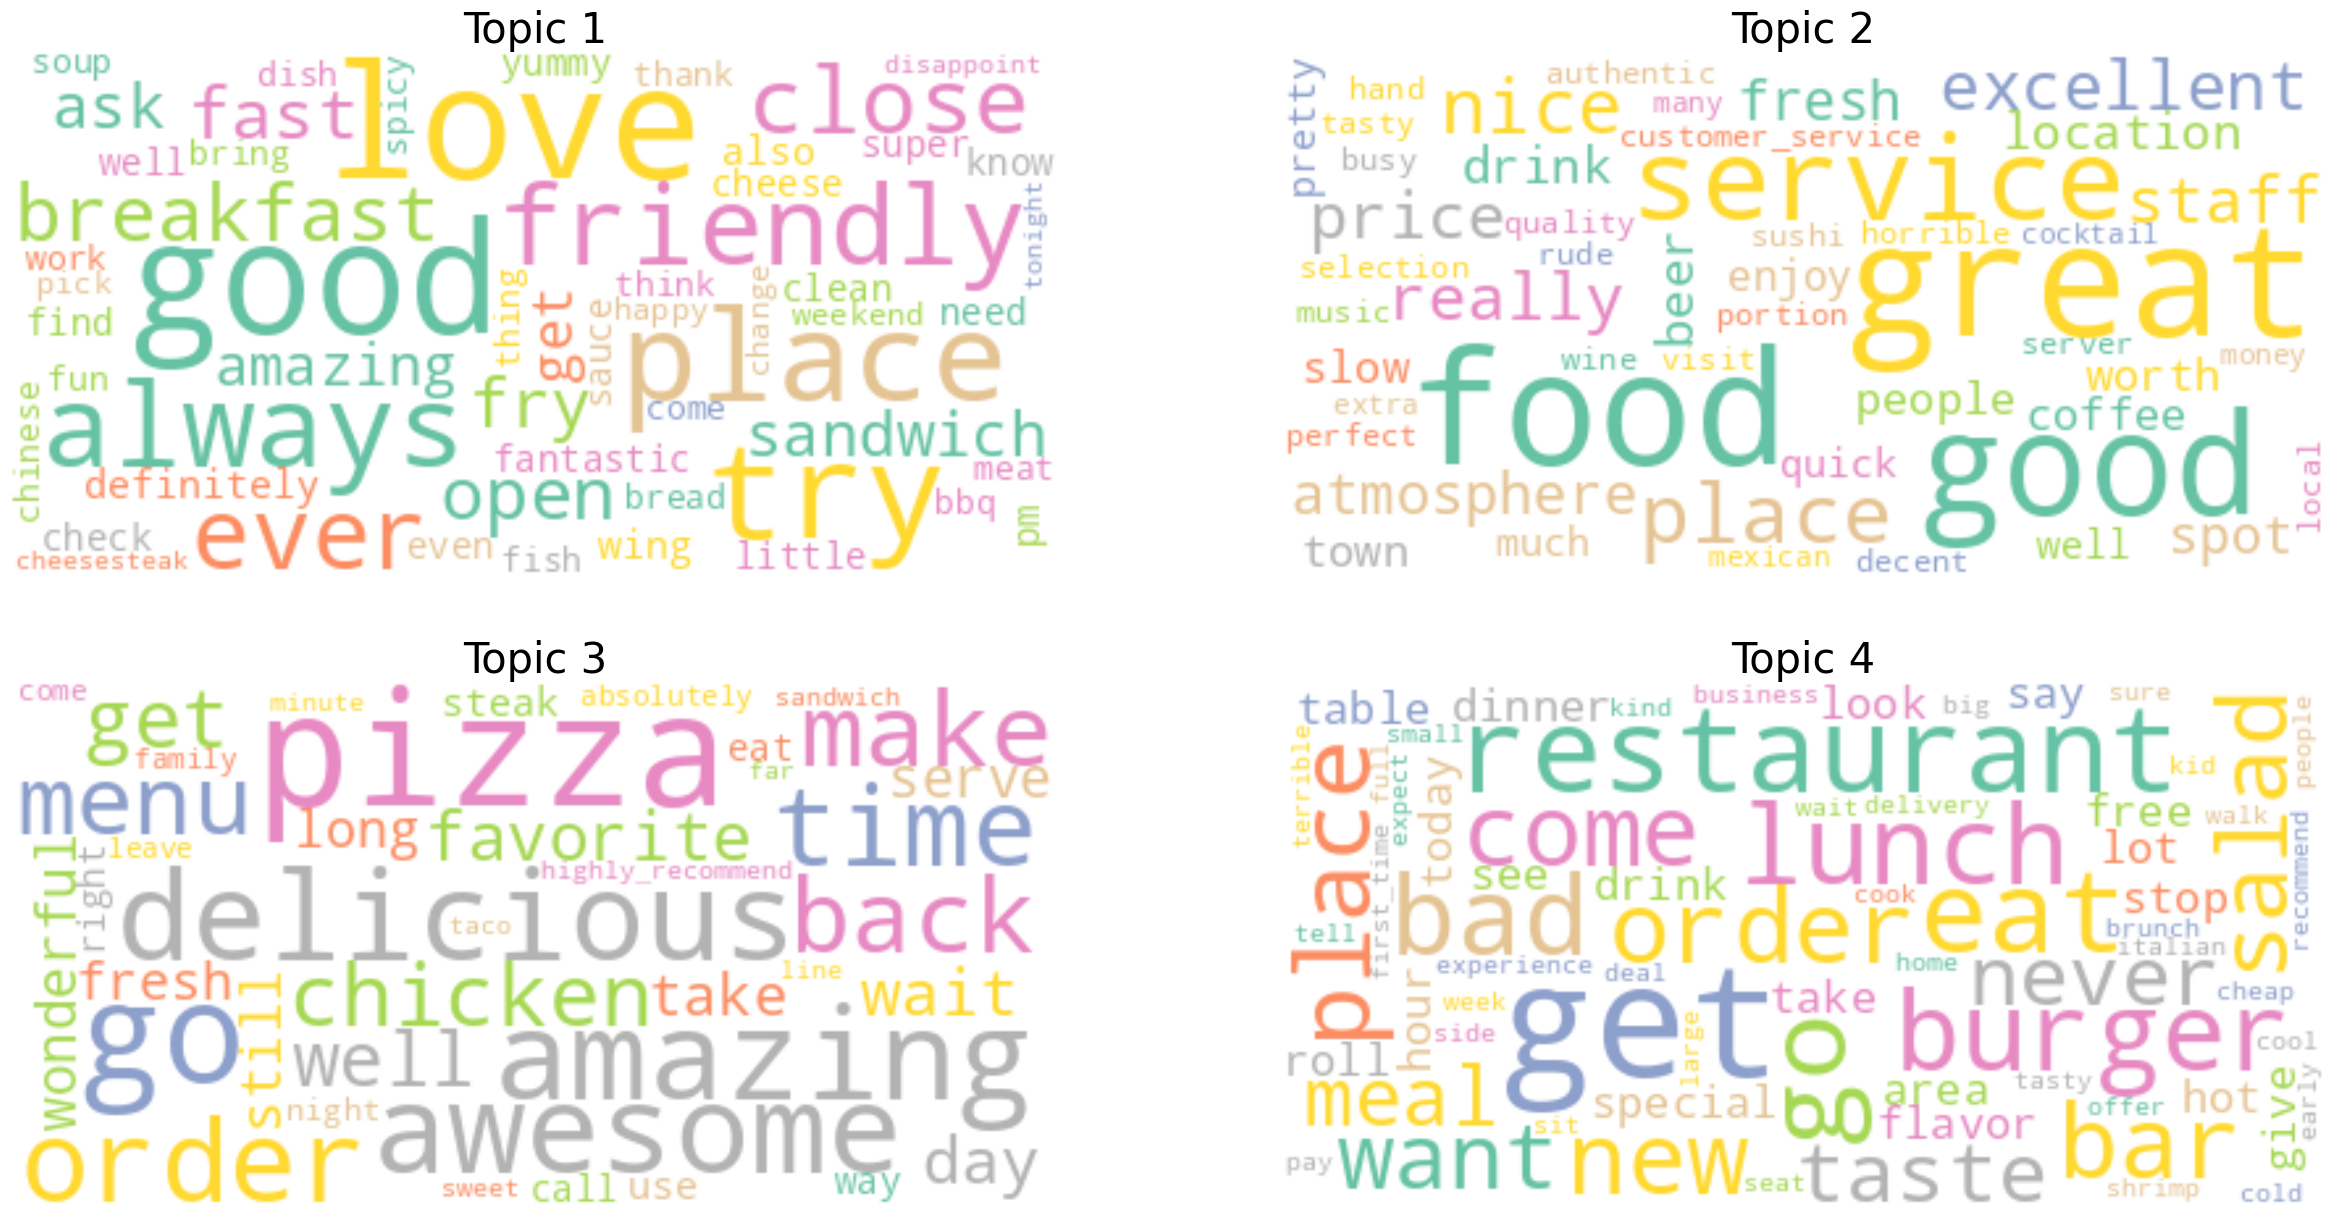

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import wordcloud

#declaring number of terms we need per topic
terms_count = 100

terms = vectorizer.get_feature_names_out()

wcloud = wordcloud.WordCloud(background_color="White",mask=None, max_words=100,\
                             max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                             contour_width=3,contour_color='Black',colormap='Set2')

fig, axes = plt.subplots(2,2, figsize=(30, 15), sharex=True)
axes = axes.flatten()

for idx,topic in enumerate(lda.components_):
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}

    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]

    ax = axes[idx]
    ax.set_title(f'Topic {idx +1}',fontdict={'fontsize': 30})
    wcloud.generate_from_frequencies(dict_word_frequency)
    ax.imshow(wcloud, interpolation='bilinear')
    ax.axis("off")
print(lda.components_)

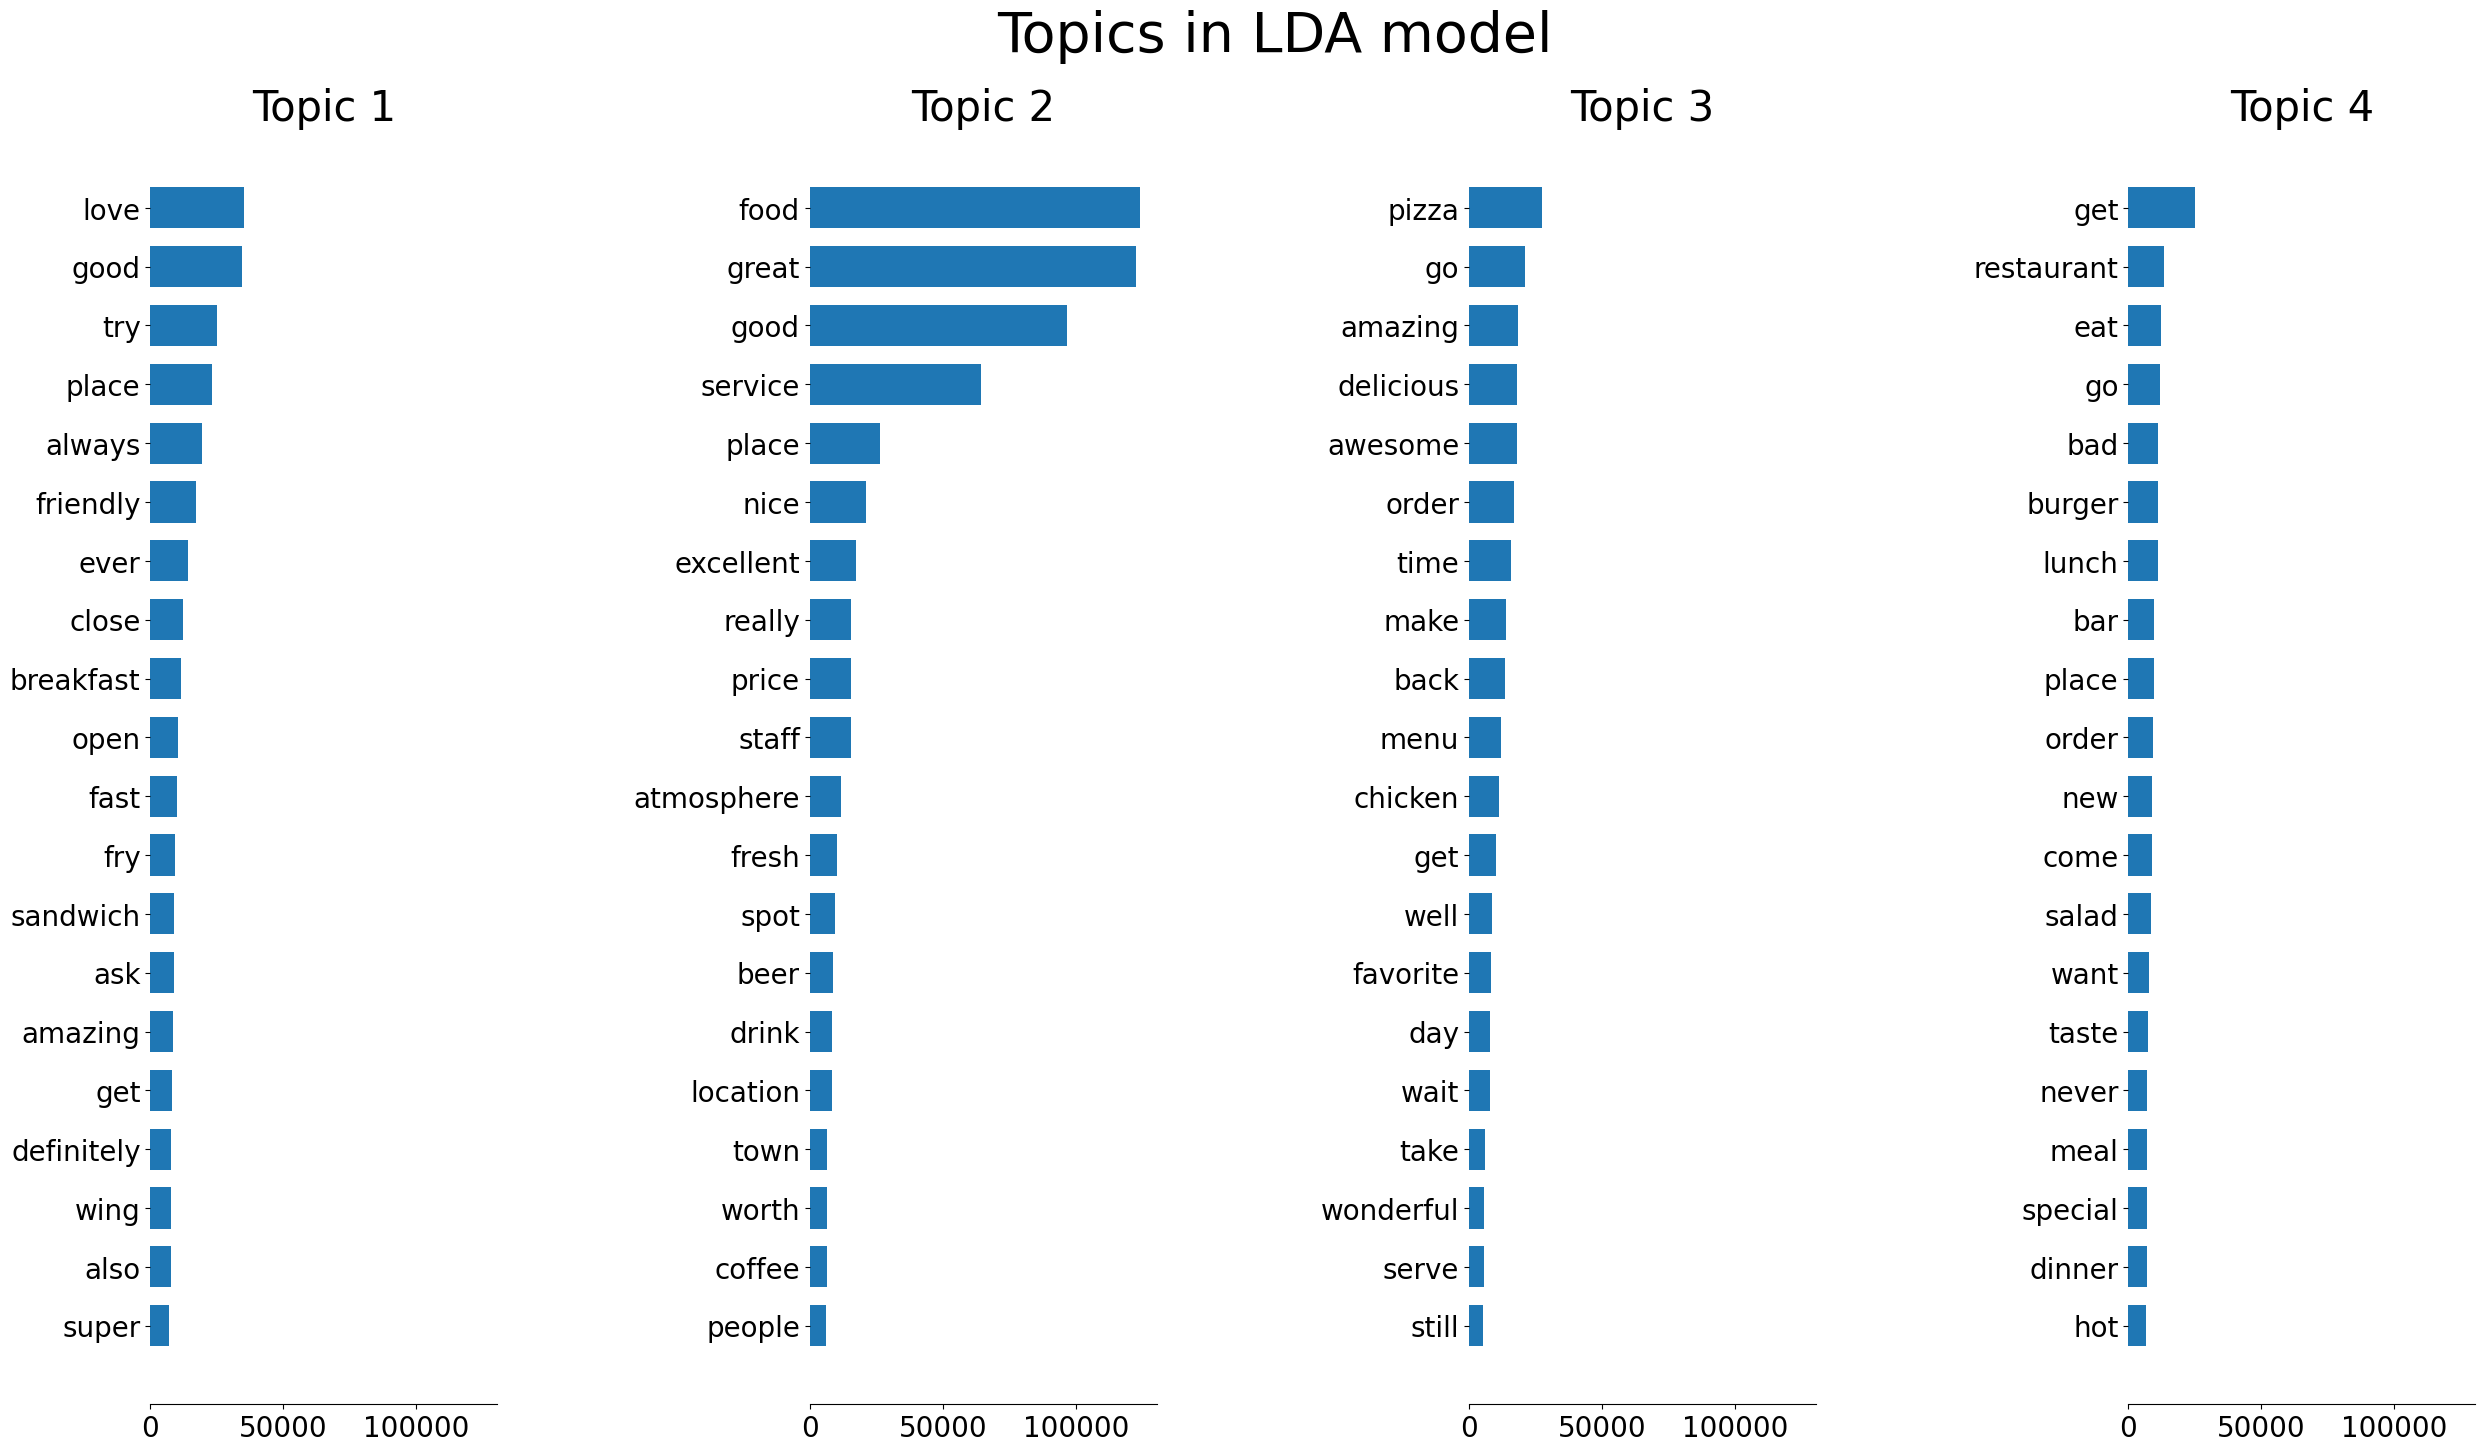

In [ ]:
# Visualise the result into bar charts in topic

%matplotlib inline
import matplotlib.pyplot as plt

# helper function to plot topics
# see Grisel et al.
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20  #how many words to be visualised in each topic

# get the list of words (feature names)
vec_feature_names = vectorizer.get_feature_names_out()

# print the top words per topic
plot_top_words(lda, vec_feature_names, n_top_words, 'Topics in LDA model')

In [ ]:
import pandas as pd
doc_topic = lda.transform(vec)
docsVStopics = pd.DataFrame(doc_topic, columns=["Topic"+str(i+1) for i in range(k)])
# tips_df = tips_df.join(docsVStopics)
# tips_df['mostlikely_topic'] = docsVStopics.idxmax(axis=1)

tips_df.to_csv('topic_modeling_result.csv', index=False) # save the file to google drive
files.download('topic_modeling_result.csv') # download the file to your local machine
docsVStopics.info()
tips_df.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606107 entries, 0 to 606106
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Topic1  606107 non-null  float64
 1   Topic2  606107 non-null  float64
 2   Topic3  606107 non-null  float64
 3   Topic4  606107 non-null  float64
dtypes: float64(4)
memory usage: 18.5 MB


,user_id,business_id,text,date,compliment_count,cleaned_review,Topic1,Topic2,Topic3,Topic4,mostlikely_topic
0,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,they have lots of good deserts and tasty cuban...,2013-02-05 18:35:10+00:00,0,lot good desert tasty cuban_sandwiche,0.051606,0.293561,0.050443,0.60439,Topic4
1,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,turkey and roast beef,2012-10-11 13:04:02+00:00,0,,0.250000,0.250000,0.250000,0.25000,Topic1
2,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,coffee and baby bread,2012-10-24 12:37:05+00:00,0,coffee baby bread,0.372677,0.502323,0.062500,0.06250,Topic2
3,boRCdL8ez95KwzWe69VoUg,QoezRbYQncpRqyrLH6Iqjg,such a great place to come and get a cuban san...,2016-10-02 16:53:40+00:00,0,great place come get cuban_sandwich smell brea...,0.471042,0.078659,0.312009,0.13829,Topic1
4,DWryovIM4VF2vim4p6WYaw,QoezRbYQncpRqyrLH6Iqjg,my last time continental and a cuban,2012-11-09 18:51:34+00:00,0,last time cuban,0.312490,0.062500,0.562510,0.06250,Topic3


In [ ]:
# First, ensure pandas-gbq is installed
# !pip install pandas-gbq

# Specify the destination table and dataset in BigQuery
# Replace 'you_dataset_name' with your dataset name where you are sending the new table to
# Replace 'new_table_name' with a name you would like to give to your table
# Replace 'your-project-id' with your project id
destination_table = 'restaurant_dataset.wordcloud_df'
project_id = 'whyso-project-0621'

# Use the to_gbq function to upload the DataFrame (after data processing) to BigQuery
tips_df.to_gbq(destination_table, project_id=project_id, if_exists='replace', progress_bar=True)

100%|██████████| 1/1 [00:00<00:00, 411.41it/s]
